# Яременко Вікторія Лабораторна 3

Завдання 2.
Розробити варіаційний автокодувальник для датасету рукописних цифр MNIST на основі багатошарової моделі. Побудувати функцію втрат. Візуалізацію розпізнавання. Порівняти результати із звичайним автокодувальником.


Epoch 1, Average Loss: 142.0080
Epoch 2, Average Loss: 115.7197
Epoch 3, Average Loss: 111.9047
Epoch 4, Average Loss: 110.0680
Epoch 5, Average Loss: 109.0081
Epoch 6, Average Loss: 108.2735
Epoch 7, Average Loss: 107.7385
Epoch 8, Average Loss: 107.2790
Epoch 9, Average Loss: 106.9348
Epoch 10, Average Loss: 106.5940


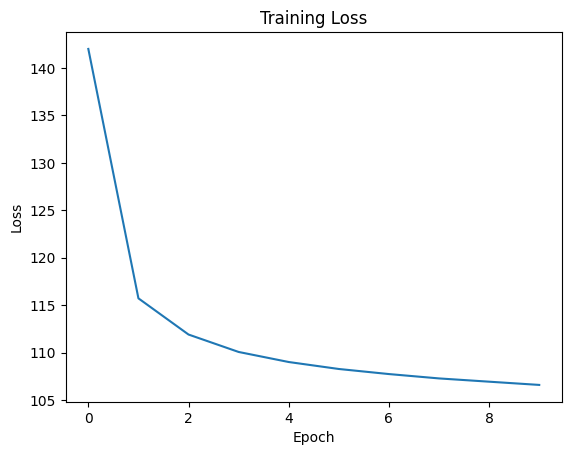

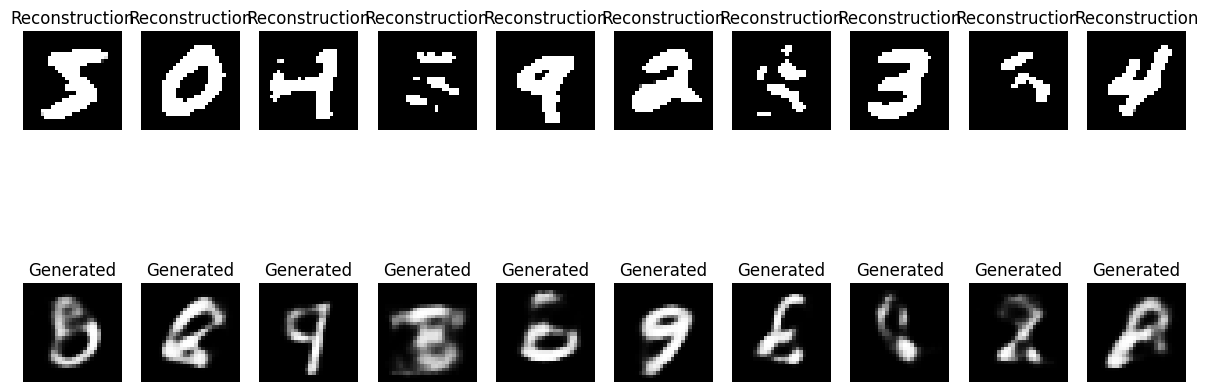

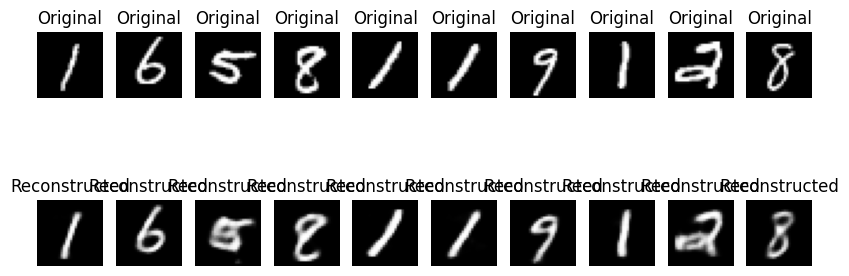

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

# Перетворення для нормалізації даних
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Завантаження даних MNIST
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Створення DataLoader
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)

# Визначення класу варіаційного автокодувальника
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim * 2)  # *2, оскільки потрібно передбачити середнє та логарифм дисперсії
        )

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()  # Для виведення значень між 0 та 1
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def forward(self, x):
        # Кодування вхідного зображення у розподіл з параметрами mu та logvar
        h = self.encoder(x)
        mu, logvar = torch.chunk(h, 2, dim=-1)

        # Повторне параметризування та зразування розподілу
        z = self.reparameterize(mu, logvar)

        # Декодування зразу в оригінальне зображення
        x_recon = self.decoder(z)

        return x_recon, mu, logvar

# Параметри моделі
input_dim = 28 * 28  # розмір зображення MNIST (28x28)
hidden_dim = 256
latent_dim = 20  # розмірність складової зразку

# Ініціалізація моделі
vae = VAE(input_dim, hidden_dim, latent_dim)

# Визначення функції втрат для варіаційного автокодувальника
def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# Оптимізатор та критерій
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

# Навчання варіаційного автокодувальника та візуалізація функції втрат
epochs = 10
losses = []
for epoch in range(epochs):
    total_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.view(-1, 28*28)  # Розгладжуємо зображення

        optimizer.zero_grad()

        recon_batch, mu, logvar = vae(data)
        loss = loss_function(recon_batch, data, mu, logvar)

        loss.backward()
        total_loss += loss.item()
        optimizer.step()

    losses.append(total_loss / len(train_loader.dataset))
    print('Epoch {}, Average Loss: {:.4f}'.format(epoch+1, total_loss / len(train_loader.dataset)))

# Побудова графіка функції втрат
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

# Візуалізація результатів реконструкції та генерації
def visualize_vae(vae, num_samples=10):
    with torch.no_grad():
        # Генерування зразків з латентного простору
        latent_samples = torch.randn(num_samples, latent_dim)
        generated_samples = vae.decoder(latent_samples).view(-1, 28, 28)

        # Реконструкція вхідних зображень
        recon_batch, _, _ = vae(train_data.data[:num_samples].view(-1, 28*28).float())
        recon_batch = recon_batch.view(-1, 28, 28)

        # Візуалізація результатів
        plt.figure(figsize=(15, 6))
        for i in range(num_samples):
            plt.subplot(2, num_samples, i + 1)
            plt.imshow(recon_batch[i].cpu().numpy(), cmap='gray')
            plt.axis('off')
            plt.title('Reconstruction')

            plt.subplot(2, num_samples, i + num_samples + 1)
            plt.imshow(generated_samples[i].cpu().numpy(), cmap='gray')
            plt.axis('off')
            plt.title('Generated')
        plt.show()

# Візуалізація результатів реконструкції та генерації
visualize_vae(vae)

# Виведення зображень та їх реконструкцій після кінцевої епохи навчання
with torch.no_grad():
    data_iter = iter(train_loader)
    images, _ = next(data_iter)
    images = images.view(-1, 28*28)
    reconstructed_images, _, _ = vae(images)
    reconstructed_images = reconstructed_images.view(-1, 28, 28)

    plt.figure(figsize=(10, 4))
    for i in range(10):
        plt.subplot(2, 10, i + 1)
        plt.imshow(images[i].cpu().numpy().reshape(28, 28), cmap='gray')
        plt.axis('off')
        plt.title('Original')

        plt.subplot(2, 10, i + 11)
        plt.imshow(reconstructed_images[i].cpu().numpy(), cmap='gray')
        plt.axis('off')
        plt.title('Reconstructed')
    plt.show()



Висновок: успішно був розроблений та навчений варіаційний автокодувальник для датасету MNIST. Модель використовується для відтворення зображень та генерації нових. Під час навчання я  спостерігала зменшення значення функції втрат, що свідчить про покращення роботи моделі. Візуалізація результатів показала ефективність реконструкції та здатність моделі генерувати нові зображення.